<a href="https://colab.research.google.com/github/electrolabopen/Facedetectorcolab/blob/master/face_landmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instalamos las bibliotecas que vamos a usar ##

In [ ]:
!pip install face_recognition

In [ ]:
!pip install deepface

## Importamos las bibliotecas ##

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import face_recognition
from deepface import DeepFace
import PIL.Image
import PIL.ImageDraw
import matplotlib.pyplot as plt

## Cargamos una imagen

In [ ]:
image = face_recognition.load_image_file("/content/sample_data/yilber.jpg")
plt.imshow(image)
plt.show()

# Buscamos una cara en la imagen

In [ ]:
# Face location
face_locations = face_recognition.face_locations(image)

for face_location in face_locations:
    crop_img = image[face_location[0]:face_location[2],face_location[3]:face_location[1]]
    plt.imshow(crop_img)
    plt.show()

## Buscamos los puntos de referencia en una cara

In [ ]:
# Found landmarks
face_landmarks = face_recognition.face_landmarks(image)
print(face_landmarks)

[{'chin': [(135, 195), (135, 209), (136, 223), (139, 238), (144, 252), (151, 265), (161, 275), (173, 283), (187, 285), (202, 282), (214, 273), (224, 262), (232, 249), (237, 235), (239, 220), (239, 205), (238, 191)], 'left_eyebrow': [(145, 172), (149, 163), (158, 158), (168, 157), (177, 160)], 'right_eyebrow': [(191, 160), (199, 157), (209, 157), (219, 161), (224, 169)], 'nose_bridge': [(185, 175), (185, 184), (186, 192), (186, 202)], 'nose_tip': [(175, 214), (180, 216), (186, 217), (191, 216), (197, 214)], 'left_eye': [(155, 182), (160, 177), (166, 176), (172, 180), (167, 183), (160, 183)], 'right_eye': [(197, 180), (203, 175), (209, 175), (214, 180), (210, 182), (203, 182)], 'top_lip': [(168, 243), (174, 235), (181, 230), (186, 232), (191, 230), (198, 234), (205, 242), (201, 241), (191, 238), (186, 238), (181, 238), (171, 242)], 'bottom_lip': [(205, 242), (198, 246), (191, 247), (186, 247), (181, 247), (175, 246), (168, 243), (171, 242), (181, 239), (186, 239), (191, 239), (201, 241)]

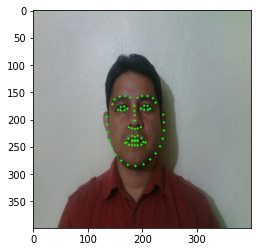

In [ ]:
for face_landmark in face_landmarks:
    for feature in face_landmark:
        #print(feature)
        landmark = face_landmark.get(feature)
        for location in landmark:
            x,y = location
            cv2.circle(image,(x, y), 2, (0,255,0), -1)

plt.imshow(image)
plt.show()

## Usando la Web Cam ##

In [ ]:
# function 
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # 
  #
  #
  
  
  face_landmarks = face_recognition.face_landmarks(img,model='large')
  faces = face_recognition.face_locations(img)

  for face in faces:
    cv2.rectangle(img,(face[3],face[2]),(face[1], face[0]),(255,2,2),3)

  if face_landmarks:
    for face_landmark in face_landmarks:
      landmark = face_landmark
      for feature in landmark:
        landmark = face_landmark.get(feature)
        for location in landmark:
          x,y = location
          cv2.circle(img,(x, y), 2, (0,255,0), -1)


  

  
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


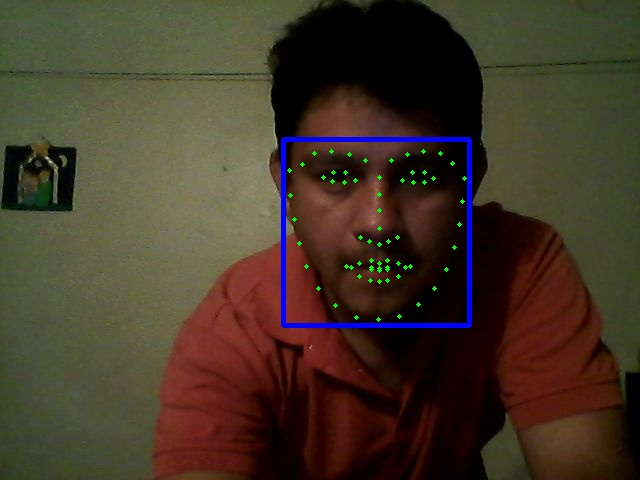

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Deepface

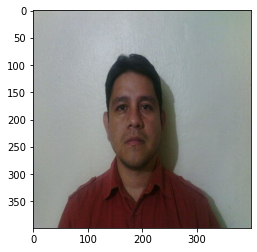

In [ ]:
# Load image
image = cv2.imread("/content/sample_data/yilber.jpg")
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show()

#Preddicion 

In [ ]:
# Prediction of emotion, gender, age, race
results = DeepFace.analyze(image)
print(results["age"]," years old ",results["dominant_race"]," ",results["dominant_emotion"]," ", results["gender"])

facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://drive.google.com/uc?id=13iUHHP3SlNg53qSuQZDdHDSDNdBP9nwy
To: /root/.deepface/weights/facial_expression_model_weights.zip
5.54MB [00:00, 32.1MB/s]


age_model_weights.h5 will be downloaded...


Downloading...
From: https://drive.google.com/uc?id=1YCox_4kJ-BYeXq27uUbasu--yz28zUMV
To: /root/.deepface/weights/age_model_weights.h5
539MB [00:14, 37.4MB/s]


gender_model_weights.h5 will be downloaded...


Downloading...
From: https://drive.google.com/uc?id=1wUXRVlbsni2FN9-jkS_f4UTUrm1bRLyk
To: /root/.deepface/weights/gender_model_weights.h5
537MB [00:06, 79.6MB/s]


race_model_single_batch.h5 will be downloaded...


Downloading...
From: https://drive.google.com/uc?id=1nz-WDhghGQBC4biwShQ9kYjvQMpO6smj
To: /root/.deepface/weights/race_model_single_batch.zip
511MB [00:04, 121MB/s]
Action: race: 100%|██████████| 4/4 [00:10<00:00,  2.60s/it]

36  years old  latino hispanic   neutral   Man


## Emocion dominante

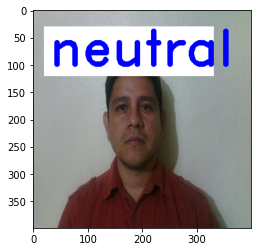

In [ ]:
cv2.rectangle(image, (20, 30), (330, 120), (255, 255, 255), cv2.FILLED)
cv2.putText(image, results['dominant_emotion'], (30,100), cv2.FONT_HERSHEY_DUPLEX, 3.0, (255, 0, 0), 5)
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show()

## Detectar Emociones con la Webcam ##

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  f_resize = 6 
  # 
  #
  #
  
  
  frame_resized = cv2.resize(img, (0, 0), fx=1/f_resize, fy=1/f_resize)
  results = DeepFace.analyze(frame_resized, actions = ['emotion'])
  cv2.putText(img, results['dominant_emotion'], (60,60), cv2.FONT_HERSHEY_DUPLEX, 1.0, (0, 0, 255), 1)

  


  

  
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

Action: emotion:   0%|          | 0/4 [00:00<?, ?it/s]

Action: race: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Saved to photo.jpg


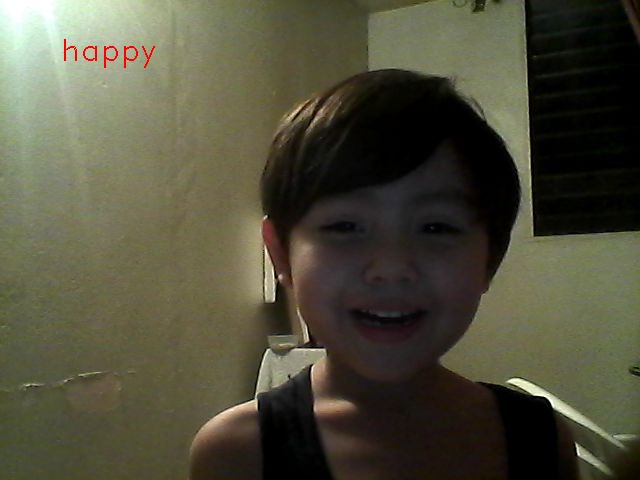

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))